### Временные ряды

План:

1. Предобработка временного ряда
2. ML для временных рядов.
2. Кросс-валидация для временных рядов

In [1]:
import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 7, 5
init_notebook_mode(connected=True)

### Предобработка временного ряда  <a name="preprocess">

> **Временной ряд** – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки. <

Таким образом, данные оказываются упорядочены относительно моментов времени, и, в отличие от случайных выборок, могут содержать в себе дополнительную информацию, которую мы постараемся извлечь. 

Возьмем датасет, в котором будет присутвовать переменная, изменяющая во времени. Давайте сегодян попробуем поработать с набором данных по среднесуточной дневной температуре в городе Дели, собранном за несколько лет. Подробнее почитать про датасет можно на [Kaggle](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)

Датасет сразу разбит на две части - train и test, но будем использовать для обучения и валидации моделей только train, оставив test как отложенную выборку для проверки качества. 

In [2]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')

print(f"Дни с {min(df.date)} по {max(df.date)}, всего {df.date.nunique()} дней.")
df.head()

Дни с 2013-01-01 по 2016-12-31, всего 1461 дней.


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
df.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

Нам понадобится колонка с датами, но сперва нужно ее преобразовать из строки в timestamp. 

In [4]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

Сразу полезно построить какой-нибудь простой линейный график, чтобы посмотреть на поведение выбранной переменной. У нас их несколько в датасете - влажность, средняя температура, скорость ветра, среднее атмосферное давленеи.

Давайте выберем среднюю температуру и обозначим за целевую переменную, которую нам нужно предскзаать. 

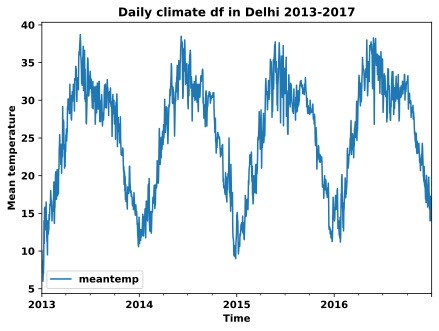

In [5]:
ax = df[['meantemp','date']].groupby('date').sum().plot(title='Daily climate df in Delhi 2013-2017')
ax.set_xlabel("Time")
ax.set_ylabel("Mean temperature"); 

Или в виде интерактивного графика в plotly:

In [6]:
df = df[['date','meantemp']].set_index('date')

In [7]:
def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)
    
plotly_df(df, 
          title="Daily climate df_train in Delhi Jan 2013 - Jan 2017")

### Генерация признаков <a name="features">

Для моделей машинного обучения нам нужны классные фичи. Давайте попробуем посмотреть, что мы можем сделать, если у нас известны только даты и целевая переменная.

Напишем функцию, которая возвращает словарь, где ключами являются уникальные категории признака cat_feature, а значениями - средние по real_feature.

In [19]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

Давай достанем из дат отдельно день недели, номер недели, номер месяца и год, и добавим их как новые признаки. 

In [20]:
data = df.copy()

data["weekday"] = data.index.weekday
data["week"] = data.index.week
data["month"] = data.index.month
data["year"] = data.index.year
data.head()

,meantemp,weekday,week,month,year
date,,,,,
2013-01-01,10.000000,1,1,1,2013
2013-01-02,7.400000,2,1,1,2013
2013-01-03,7.166667,3,1,1,2013
2013-01-04,8.666667,4,1,1,2013
2013-01-05,6.000000,5,1,1,2013


Среднее значение целевой переменной по месяцам:

In [23]:
code_mean(data, "month", "meantemp")

{1: 13.3386232718894,
 2: 17.62042216632924,
 3: 22.914103302611363,
 4: 29.37661439255189,
 5: 33.315889185268674,
 6: 33.7340106074481,
 7: 30.995781565314307,
 8: 30.601776852904102,
 9: 30.433215874175826,
 10: 27.113154309004592,
 11: 20.656854544822888,
 12: 15.666317026303089}

Можно это удобно обернуть в функцию и заменить исходные признаки на их среднее как один из вариантов препроцессинга, а также - добавить значения целевой переменной с разной длинной временного лага.

In [21]:
def preprocess_data(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.meantemp.shift(i)

    data["weekday"] = data.index.weekday
    data["week"] = data.index.week
    data["month"] = data.index.month
    data["year"] = data.index.year

    # считаем средние только по тренировочной части, чтобы избежать лика
    data["weekday_average"] = list(map(code_mean(data[:test_index], "weekday", "meantemp").get, data.weekday))
    data["week_average"] = list(map(code_mean(data[:test_index], "week", "meantemp").get, data.week))
    data["month_average"] = list(map(code_mean(data[:test_index], "month", "meantemp").get, data.month))
    data["year_average"] = list(map(code_mean(data[:test_index], "year", "meantemp").get, data.year))
    
    # выкидываем закодированные средними признаки
    data.drop(["weekday", "week", 'month', 'year'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["meantemp"], axis=1)
    y_train = data.loc[:test_index]["meantemp"]
    X_test = data.loc[test_index:].drop(["meantemp"], axis=1)
    y_test = data.loc[test_index:]["meantemp"]

    return X_train, X_test, y_train, y_test

### Кросс-валидация для временных рядов <a name="cv">

Обратите внимание, что в функции мы сами по индексу разбили датасет на обучающую и валидационную выборку для обучения моделей. Мы не можем воспользовать train_test_split, так как нам необходимо сохранять хронологию в деление выборки на части, т.е. случайное сэмплирование наблюдений нам не подойдет, в частности, т.к. мы хотим выучить тренд в данных.

<img src='https://miro.medium.com/max/558/1*AXRu72CV1hdjLfODFGbMWQ.png'>

Обучим линейную регрессию:

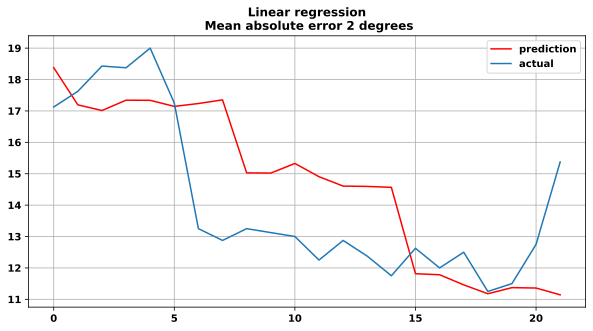

In [26]:
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = preprocess_data(df, test_size=0.3, lag_start=12, lag_end=48)

lr = LinearRegression()
#lr = CatBoostRegressor(n_estimators=300)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {round(mean_absolute_error(preds, y_test))} degrees");

Теперь, давайте сделаем не один сплит, а как на картинке в тексте - time-aware кросс-валидацию.

Можно воспользоваться TimeSeriesSplit из sklearn:

In [29]:
from sklearn.model_selection import TimeSeriesSplit

y = pd.concat([y_train, y_test], axis=0)
X = pd.concat([X_train, X_test], axis=0)

errors = []

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    errors.append(mean_absolute_error(preds, y_test))
    
np.mean(errors)

1.8610802096771475